# Setup

## Importing Packages

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import calendar

import warnings
warnings.filterwarnings("ignore")

## Utility Functions

In [15]:
def dataframe_info(df):
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Count', 'Unique Sample', 'Missing Values', 'Missing Percentage'])
    for column in df.columns:
        data_type = df[column].dtype
        unique_count = df[column].nunique()
        unique_sample = df[column].unique()[:5]
        missing_values = df[column].isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        report = pd.concat([report, pd.DataFrame({'Column': [column],
                                                      'Data Type': [data_type],
                                                      'Unique Count': [unique_count],
                                                      'Unique Sample': [unique_sample],
                                                      'Missing Values': [missing_values],
                                                      'Missing Percentage': [missing_percentage.round(4)]})],
                             ignore_index=True)
    return report

# Data Preprocessing

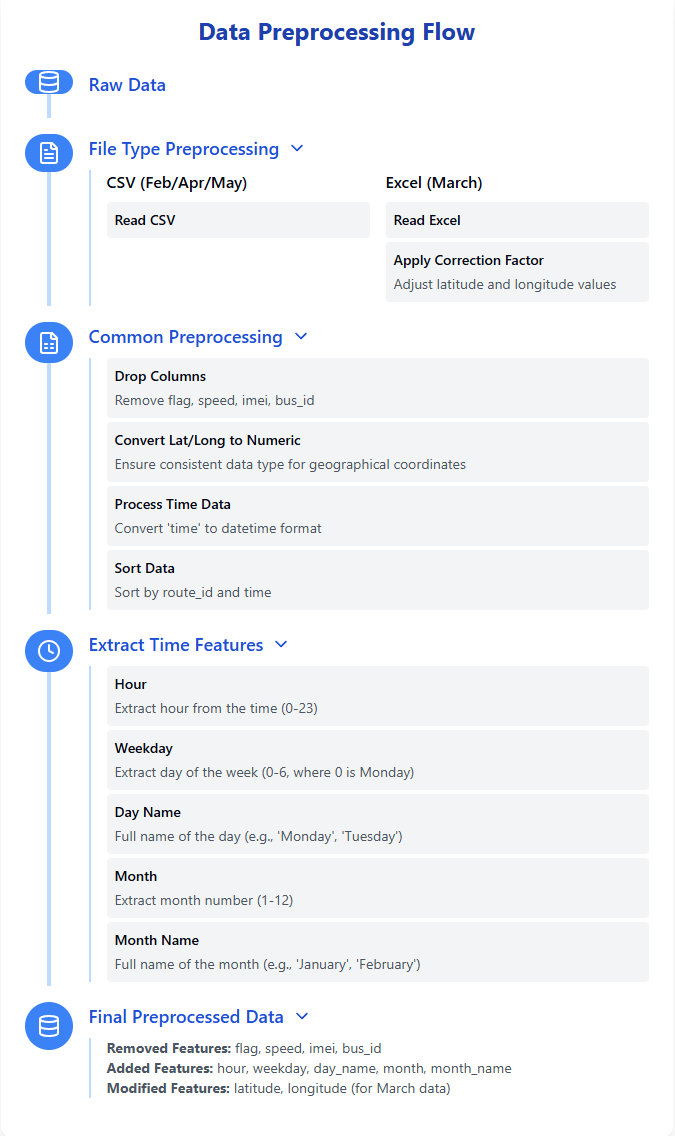

In [74]:
def load_and_prepare_data(file_path, file_type='csv', correction_factor=None):
    # Load data
    if file_type == 'csv':
        df = pd.read_csv(file_path)
    elif file_type == 'excel':
        df = pd.read_excel(file_path)

    # Drop unnecessary columns
    df.drop(['flag', 'speed', 'imei', 'bus_id'], axis=1, inplace=True)

    # Convert latitude and longitude to numeric, handling different possible formats
    def convert_to_numeric(x):
        if isinstance(x, (int, float)):
            return x
        elif isinstance(x, str):
            return pd.to_numeric(x.replace(',', '.'), errors='coerce')
        else:
            return np.nan

    df['latitude'] = df['latitude'].apply(convert_to_numeric)
    df['longitude'] = df['longitude'].apply(convert_to_numeric)

    # Correct latitude and longitude if needed
    if correction_factor:
        df['latitude'] = df['latitude'] / correction_factor
        df['longitude'] = df['longitude'] / correction_factor

    # Convert 'time' to datetime and sort data
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df.sort_values(by=['route_id', 'time'], inplace=True)

    # Extract time-related features
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.weekday
    df['day_name'] = df['time'].dt.day_name()
    df['month'] = df['time'].dt.month
    
    # Apply a lambda function to convert month numbers to names
    df['month_name'] = df['month'].apply(lambda x: calendar.month_name[x])

    return df

# Load and prepare data for each month
feb_df = load_and_prepare_data('D:\\CDS590\\data\\raw\\location_data_Feb2024.csv', file_type='csv')
march_df = load_and_prepare_data('D:\\CDS590\\data\\raw\\data_march_2024.xlsx', file_type='excel', correction_factor=100000)
april_df = load_and_prepare_data('D:\\CDS590\\data\\raw\\data_april.csv', file_type='csv')
may_df = load_and_prepare_data('D:\\CDS590\\data\\raw\\location_data_May2024.csv', file_type='csv')

# Data Cleaning

## merging the data

In [75]:
# Concatenate the three DataFrames
merged_df = pd.concat([feb_df, march_df, april_df, may_df])

# Reset the index to ensure it's sequential
merged_df.reset_index(drop=True, inplace=True)

## removing weekend data

In [26]:
merged_df

,route_id,latitude,longitude,time,hour,weekday,day_name,month,month_name
0,10,-7.93324,112.60354,2024-02-01 06:54:08,6,3,Thursday,2,February
1,10,-7.93324,112.60354,2024-02-01 06:58:14,6,3,Thursday,2,February
2,10,-7.94329,112.61047,2024-02-01 07:00:07,7,3,Thursday,2,February
3,10,-7.94979,112.61559,2024-02-01 07:09:44,7,3,Thursday,2,February
4,10,-7.94979,112.61559,2024-02-01 07:09:49,7,3,Thursday,2,February
...,...,...,...,...,...,...,...,...,...
2294,11,-7.94331,112.61043,2024-05-31 14:27:57,14,4,Friday,5,May
2295,11,-7.94331,112.61043,2024-05-31 14:28:11,14,4,Friday,5,May
2296,11,-7.94331,112.61043,2024-05-31 14:28:27,14,4,Friday,5,May
2297,11,-7.94331,112.61043,2024-05-31 14:28:40,14,4,Friday,5,May


In [76]:
filtered_df = merged_df.copy(deep=True)
# Remove weekend data (Saturday = 5, Sunday = 6)
filtered_df = filtered_df[filtered_df['weekday'].isin([0, 1, 2, 3, 4])]

## Estimating expected records based on holidays

february: 21 days
march: 21 days
april: 18 days
may: 24 days

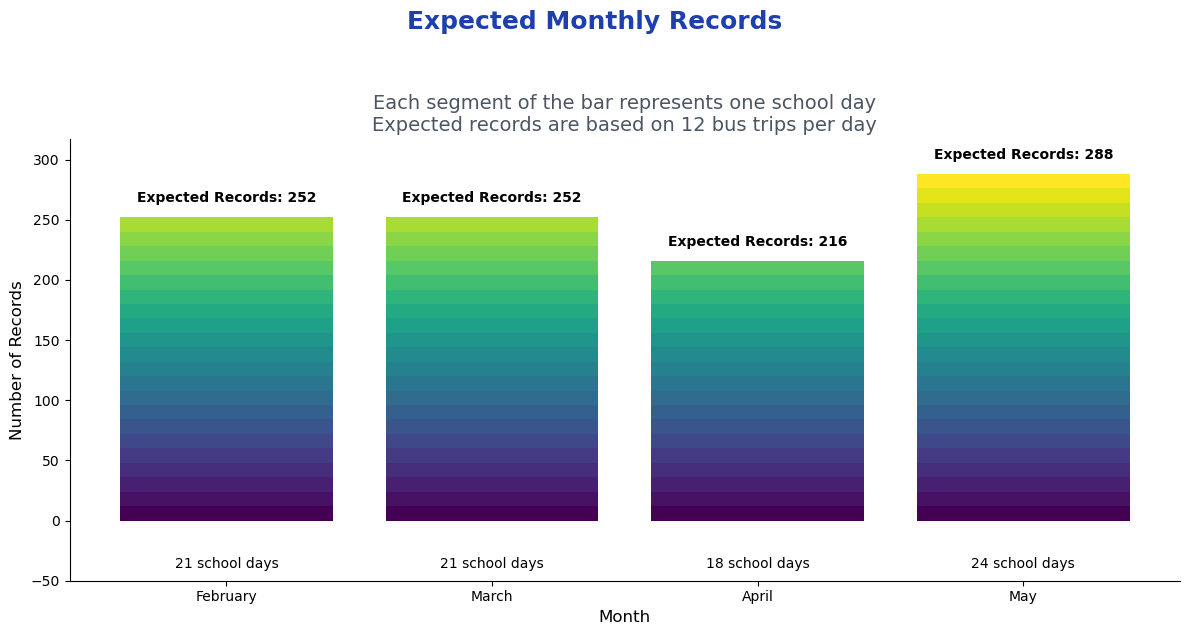

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a DataFrame with the monthly data
data = pd.DataFrame({
    'month': ['February', 'March', 'April', 'May'],
    'days': [21, 21, 18, 24],
    'records': [21 * 12, 21 * 12, 18 * 12, 24 * 12]
})

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define the colors for the stacks
colors = plt.cm.viridis(np.linspace(0, 1, max(data['days'])))

# Plot the stacked bar chart
for idx, row in data.iterrows():
    bottom = 0
    for day in range(row['days']):
        ax.bar(row['month'], 12, bottom=bottom, color=colors[day])
        bottom += 12

# Add multi-line title with enhanced styling
plt.suptitle('Expected Monthly Records', fontsize=18, fontweight='bold', color='#1e40af', y=1.05)
plt.title('Each segment of the bar represents one school day\nExpected records are based on 12 bus trips per day', fontsize=14, color='#4b5563')

# Customize the chart
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

# Add total records and school days as text labels
for i, row in enumerate(data.itertuples()):
    plt.text(i, row.records + 10, f'Expected Records: {row.records:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i, -30, f'{row.days} school days', ha='center', va='top', fontsize=10)

# Adjust y-axis to make room for bottom text
plt.ylim(-50, max(data['records']) * 1.1)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
print('Total expected records:', (21*12)+(21*12)+(18*12)+(24*12))

Total expected records: 1008


## Filtering the hours for each month

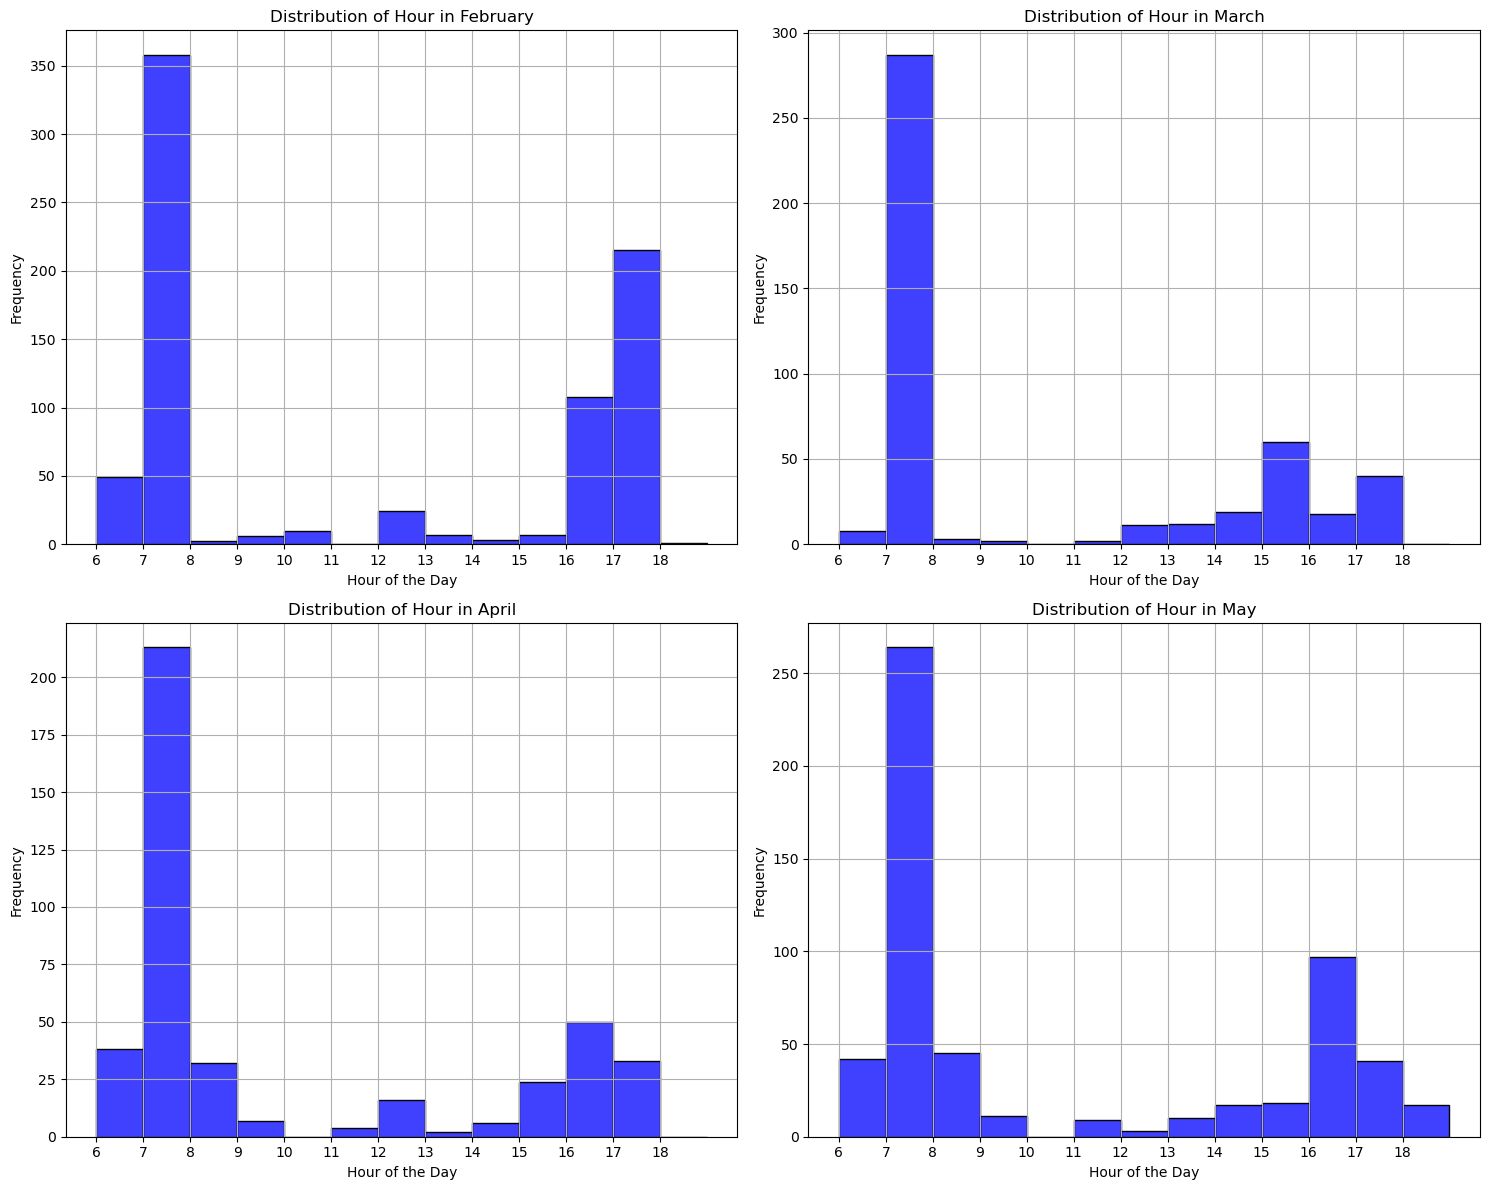

In [14]:
def plot_hour_distribution(df, month_name, ax):
    sns.histplot(df['hour'], bins=range(6, 20), kde=False, color='blue', ax=ax)  # bins from 6 to 18
    ax.set_title(f'Distribution of Hour in {month_name}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(6, 19))  # Set x ticks to represent hours from 6 to 18
    ax.grid(True)

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot for each month
plot_hour_distribution(feb_df, 'February', axes[0, 0])
plot_hour_distribution(march_df, 'March', axes[0, 1])
plot_hour_distribution(april_df, 'April', axes[1, 0])
plot_hour_distribution(may_df, 'May', axes[1, 1])

plt.tight_layout()
plt.show()

In [48]:
# Extract the time component
filtered_df['time_component'] = filtered_df['time'].dt.time

# Define the time ranges
morning_start = pd.to_datetime('06:30:00').time()
morning_end = pd.to_datetime('08:00:00').time()
afternoon_start = pd.to_datetime('15:00:00').time()
afternoon_end = pd.to_datetime('18:00:00').time()

# Filter the DataFrame
filtered_df = filtered_df[
    ((filtered_df['time_component'] >= morning_start) & (filtered_df['time_component'] <= morning_end)) |
    ((filtered_df['time_component'] >= afternoon_start) & (filtered_df['time_component'] <= afternoon_end))
]

filtered_df.drop(columns=['time_component'], inplace=True)

In [49]:
actual_records = filtered_df.groupby('month_name').size().reset_index(name='actual_records')

expected_records = pd.DataFrame({
    'month_name': ['February', 'March', 'April', 'May'],
    'days': [21, 21, 18, 24],
    'expected_records': [21 * 12, 21 * 12, 18 * 12, 24 * 12]
})

# Merge the actual and expected records
comparison_df = pd.merge(expected_records, actual_records, on='month_name', how='left')
comparison_df['actual_records'] = comparison_df['actual_records'].fillna(0)  # Fill NaNs with 0 if any month has no records
comparison_df['difference'] = comparison_df['actual_records'] - comparison_df['expected_records']

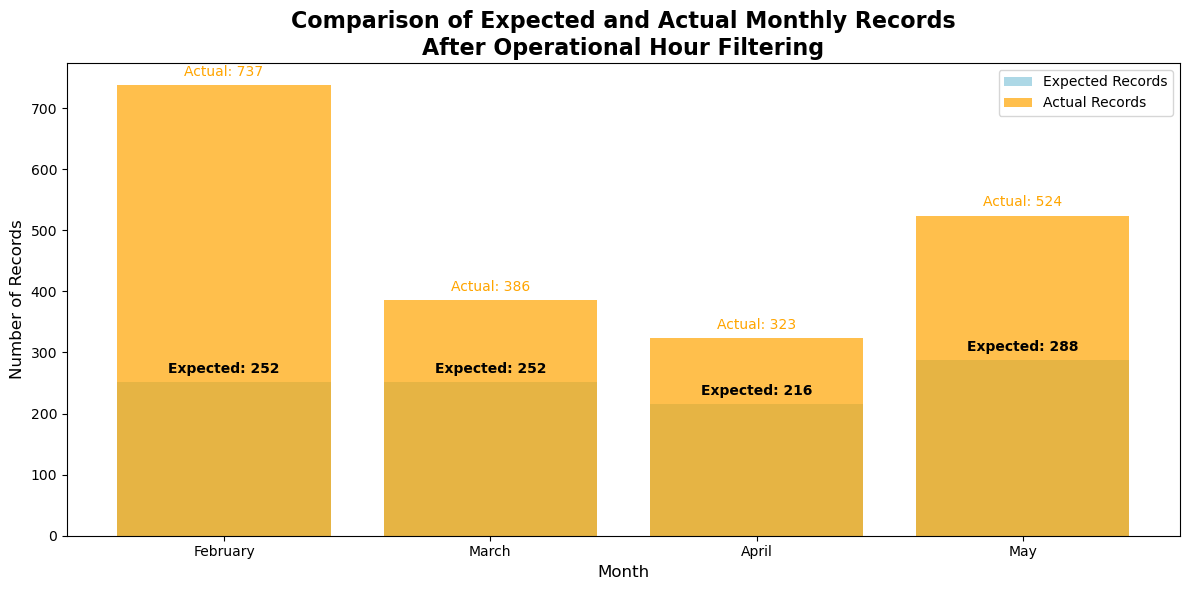

In [77]:
# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot expected records
ax.bar(comparison_df['month_name'], comparison_df['expected_records'], label='Expected Records', color='lightblue')

# Plot actual records
ax.bar(comparison_df['month_name'], comparison_df['actual_records'], label='Actual Records', color='orange', alpha=0.7)

# Customize the chart
plt.title('Comparison of Expected and Actual Monthly Records\nAfter Operational Hour Filtering', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.legend()

# Add text labels
for i, row in comparison_df.iterrows():
    plt.text(i, row['expected_records'] + 10, f'Expected: {row["expected_records"]}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i, row['actual_records'] + 10, f'Actual: {row["actual_records"]}', ha='center', va='bottom', fontsize=10, color='orange')

# Show the plot
plt.tight_layout()
plt.show()


In [51]:
len(filtered_df)

1970

## Standardizing Coordinates

In [32]:
from geopy.distance import geodesic
import geopandas as gpd
from shapely.geometry import LineString, Point
from haversine import haversine
from geopy.distance import geodesic

from sklearn.cluster import DBSCAN


In [52]:
def perform_clustering(df):
    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)],
        crs="EPSG:4326"
    )

    # Apply DBSCAN clustering
    db = DBSCAN(eps=0.001, min_samples=5).fit(np.array(gdf.geometry.apply(lambda p: (p.x, p.y)).tolist()))
    gdf['cluster_id'] = db.labels_

    return gdf  # Return only the GeoDataFrame with added cluster labels


def renumber_clusters_based_on_stop_id(gdf):
    # Ensure 'Stop_Id' is sorted in the order you want (e.g., 'BT01', 'BT02', ..., 'BT08')
    ordered_stops = ['BT01', 'BT02', 'BT03', 'BT04', 'BT05', 'BT06', 'BT07', 'BT08']

    # Create a mapping from Stop_Id to a sequential number starting from 1
    stop_id_to_sequential = {stop: i + 1 for i, stop in enumerate(ordered_stops)}

    # Apply this mapping to the Stop_Id to create a new sequential cluster_id
    gdf['sequential_cluster_id'] = gdf['Stop_Id'].map(stop_id_to_sequential)

    return gdf

filtered_gdf = perform_clustering(filtered_df)

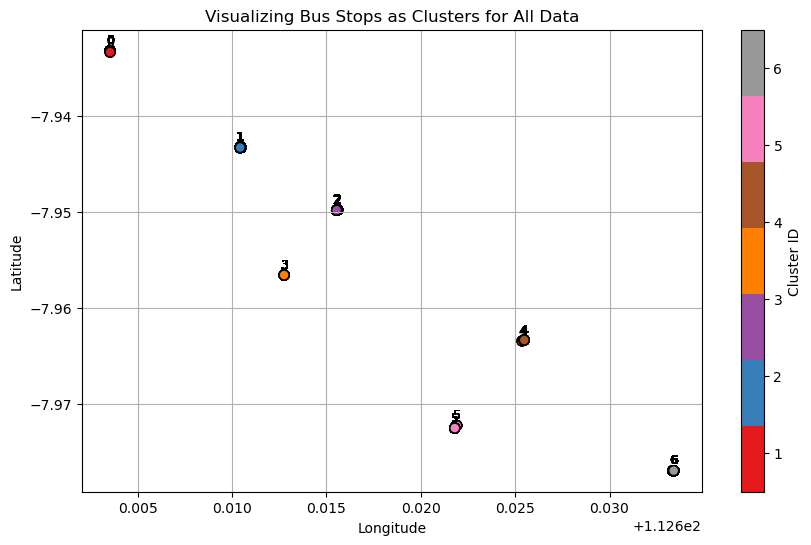

In [53]:
def plot_clusters(gdf, month_name):
    # Set up the plot
    plt.figure(figsize=(10, 6))
    # Generate a discrete colormap
    num_clusters = gdf['cluster_id'].nunique()
    cmap = plt.cm.get_cmap('Set1', num_clusters)  # Get a colormap with `num_clusters` discrete colors

    # Scatter plot for clusters
    scatter = plt.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf['cluster_id'], cmap=cmap, edgecolor='k', s=50)

    # Create colorbar with discrete boundaries
    cbar = plt.colorbar(scatter, ticks=np.arange(num_clusters)+0.5, spacing='proportional')
    cbar.set_ticklabels(np.arange(1, num_clusters+1))
    cbar.set_label('Cluster ID')

    # Annotate each point with its cluster ID
    for i, point in gdf.iterrows():
        plt.annotate(text=str(point['cluster_id']), xy=(point.geometry.x, point.geometry.y),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)

    plt.title(f'Visualizing Bus Stops as Clusters for {month_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)  # Optional: turn on grid for better alignment
    plt.show()
    
plot_clusters(filtered_gdf, "All Data")

In [85]:
def standardize_bus_stop_locations(gdf):
    """
    Standardizes bus stop locations by calculating the modal coordinates for each cluster
    represented by 'cluster_id'. These modal coordinates represent the most
    common GPS coordinates for each bus stop, presumed to be the actual location of the stops.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame containing the bus stop data with clusters.

    Returns:
    GeoDataFrame: The updated GeoDataFrame with standardized bus stop coordinates.
    """

    # Function to calculate the modal point for each group of points
    def calculate_modal_point(geometry):
        x_coords = [point.x for point in geometry]
        y_coords = [point.y for point in geometry]
        x_mode = pd.Series(x_coords).mode()[0]  # Most frequent x coordinate
        y_mode = pd.Series(y_coords).mode()[0]  # Most frequent y coordinate
        return Point(x_mode, y_mode)

    # Grouping the data by 'cluster_id' and calculating modal point for each group
    bus_stop_centroids = gdf.groupby('cluster_id').agg({
        'geometry': calculate_modal_point  # Applying the modal point function to the 'geometry' column
    }).reset_index().rename(columns={'geometry': 'geometry_standard'})

    # Merging the modal points back into the original GeoDataFrame
    gdf = gdf.merge(bus_stop_centroids, on='cluster_id', suffixes=('', '_standard'))

    # Replace latitude and longitude columns with the standardized geometry
    gdf['latitude'] = gdf['geometry_standard'].apply(lambda point: point.y)
    gdf['longitude'] = gdf['geometry_standard'].apply(lambda point: point.x)

    return gdf

def add_stop_info(df):
    """
    Adds Stop_Name and Stop_ID columns to the DataFrame based on cluster_id.

    Parameters:
    - df: DataFrame containing the cluster_id column.
    - stop_info: Dictionary mapping cluster_id to Stop_Name and Stop_ID.
    """

    # Stop information for each month
    cluster_stop_map = {
        0: ('SPBU Tlogomas', 'BT01'),
        1: ('SD Dinoyo 2', 'BT02'),
        2: ('SMA 9', 'BT03'),
        3: ('SMA 8', 'BT04'),
        4: ('MAN 2', 'BT05'),
        5: ('SMA Dempo', 'BT06'),
        6: ('SMP 4', 'BT07')
    }

    df['Stop_Name'] = df['cluster_id'].map(lambda x: cluster_stop_map[x][0])
    df['Stop_ID'] = df['cluster_id'].map(lambda x: cluster_stop_map[x][1])
    return df


def remove_clustering_columns(gdf):
    gdf = gdf.drop(columns=['cluster_id', 'geometry'])
    return gdf

def remove_noise(df, cluster_col='cluster_id'):
    """
    Removes rows labeled as noise in the specified cluster column.

    Parameters:
    - df: DataFrame containing the cluster column.
    - cluster_col: The column name for the cluster labels (default is 'cluster_id').

    Returns:
    - DataFrame with noise rows removed.
    """
    return df[df[cluster_col] != -1]

standardized_filtered_df = standardize_bus_stop_locations(filtered_gdf)
standardized_filtered_df = add_stop_info(standardized_filtered_df)
standardized_filtered_df = remove_noise(standardized_filtered_df)
standardized_filtered_df = remove_clustering_columns(standardized_filtered_df)

In [55]:
# Plotting function to visualize the standardized results
def plot_standardized_stops(gdf, month_name):
    plt.figure(figsize=(10, 6))
    # Original points
    plt.scatter(gdf.geometry.x, gdf.geometry.y, color='blue', label='Original Points')
    # Standardized bus stop locations
    plt.scatter(gdf.geometry_standard.x, gdf.geometry_standard.y, color='red', label='Standardized Bus Stops', marker='x')
    plt.title(f'Bus Stops Standardization for {month_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

In [62]:
standardized_filtered_df

,route_id,latitude,longitude,time,hour,weekday,day_name,month,month_name,Stop_Name,Stop_ID
0,10,-7.93324,112.60354,2024-02-01 06:54:08,6,3,Thursday,2,February,SPBU Tlogomas,BT01
1,10,-7.93324,112.60354,2024-02-01 06:58:14,6,3,Thursday,2,February,SPBU Tlogomas,BT01
2,10,-7.94329,112.61047,2024-02-01 07:00:07,7,3,Thursday,2,February,SD Dinoyo 2,BT02
3,10,-7.94979,112.61559,2024-02-01 07:09:44,7,3,Thursday,2,February,SMA 9,BT03
4,10,-7.94979,112.61559,2024-02-01 07:09:49,7,3,Thursday,2,February,SMA 9,BT03
...,...,...,...,...,...,...,...,...,...,...,...
1965,11,-7.97250,112.62180,2024-05-28 16:12:17,16,1,Tuesday,5,May,SMA Dempo,BT06
1966,11,-7.94979,112.61559,2024-05-28 16:49:47,16,1,Tuesday,5,May,SMA 9,BT03
1967,11,-7.94329,112.61047,2024-05-28 16:52:31,16,1,Tuesday,5,May,SD Dinoyo 2,BT02
1968,11,-7.94329,112.61047,2024-05-28 16:52:45,16,1,Tuesday,5,May,SD Dinoyo 2,BT02


## removing duplicates

In [140]:
from datetime import timedelta

def mark_and_remove_consecutive_duplicates(df, column_list, time_col='time', minutes=5):
    """
    Marks consecutive duplicates within a specified time window and removes them,
    keeping the first entry of each duplicate set.
    """
    # Ensure the DataFrame is sorted for proper sequential comparison
    df.sort_values(by=[time_col] + column_list, inplace=True)

    # Initialize a column to mark duplicates
    df['is_duplicate'] = False

    # Use shift to compare each row with the previous one
    previous_rows = df.shift(1)
    time_diff = (df[time_col] - previous_rows[time_col]).abs() <= timedelta(minutes=minutes)

    # Check for duplication in specified columns and within the time window
    for column in column_list:
        df['is_duplicate'] |= (df[column] == previous_rows[column]) & time_diff

    # Keep only the first record of duplicates by marking subsequent ones
    # First record will not be marked since there's no previous duplicate within the window
    cleaned_df = df[~df['is_duplicate']].drop(columns=['is_duplicate'])
    return cleaned_df

column_list = ['geometry_standard']  # Columns to consider for duplicate checking

standardized_filtered_deduped_df = mark_and_remove_consecutive_duplicates(standardized_filtered_df, column_list)

# Optionally, print the size of the original and cleaned datasets to see how many entries were removed
print(f"Original: {len(standardized_filtered_df)}, Cleaned: {len(standardized_filtered_deduped_df)}")

Original: 1970, Cleaned: 795


In [118]:
standardized_filtered_df

,route_id,latitude,longitude,time,hour,weekday,day_name,month,month_name,geometry_standard,Stop_Name,Stop_ID,is_duplicate
0,10,-7.93324,112.60354,2024-02-01 06:54:08,6,3,Thursday,2,February,POINT (112.60354 -7.93324),SPBU Tlogomas,BT01,False
1,10,-7.93324,112.60354,2024-02-01 06:58:14,6,3,Thursday,2,February,POINT (112.60354 -7.93324),SPBU Tlogomas,BT01,True
2,10,-7.94329,112.61047,2024-02-01 07:00:07,7,3,Thursday,2,February,POINT (112.61047 -7.94329),SD Dinoyo 2,BT02,False
3,10,-7.94979,112.61559,2024-02-01 07:09:44,7,3,Thursday,2,February,POINT (112.61559 -7.94979),SMA 9,BT03,False
4,10,-7.94979,112.61559,2024-02-01 07:09:49,7,3,Thursday,2,February,POINT (112.61559 -7.94979),SMA 9,BT03,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,10,-7.97250,112.62180,2024-05-31 07:26:24,7,4,Friday,5,May,POINT (112.6218 -7.9725),SMA Dempo,BT06,False
1810,10,-7.97693,112.63340,2024-05-31 07:32:19,7,4,Friday,5,May,POINT (112.6334 -7.97693),SMP 4,BT07,False
1811,10,-7.97693,112.63340,2024-05-31 07:32:43,7,4,Friday,5,May,POINT (112.6334 -7.97693),SMP 4,BT07,True
1812,10,-7.97693,112.63340,2024-05-31 07:32:57,7,4,Friday,5,May,POINT (112.6334 -7.97693),SMP 4,BT07,True


In [183]:
import pandas as pd
from datetime import timedelta

def remove_duplicates_standardized(df, geom_col='geometry_standard', time_col='time', time_threshold=timedelta(minutes=5)):
    """
    Removes duplicates from standardized GPS data based on the standardized location and time proximity.
    
    :param df: DataFrame with standardized GPS data
    :param geom_col: Name of the column containing standardized Point objects
    :param time_col: Name of the column containing timestamps
    :param time_threshold: Time threshold for considering points as duplicates
    :return: DataFrame with duplicates removed
    """
    print(f"Initial shape: {df.shape}")
    
    # Sort the dataframe by time
    df_sorted = df.sort_values(by=time_col)
    
    # Initialize list to keep track of rows to keep
    rows_to_keep = []
    
    # Iterate through sorted dataframe
    for i, row in df_sorted.iterrows():
        if not rows_to_keep:
            # Always keep the first row
            rows_to_keep.append(i)
        else:
            # Get the last kept row
            last_kept = df_sorted.loc[rows_to_keep[-1]]
            
            # Check if current row has a different standardized location or is beyond time threshold
            if (row[geom_col] != last_kept[geom_col] or 
                (row[time_col] - last_kept[time_col]) > time_threshold):
                rows_to_keep.append(i)
    
    # Create new dataframe with only the rows to keep
    df_deduplicated = df_sorted.loc[rows_to_keep]
    
    print(f"Shape after removing duplicates: {df_deduplicated.shape}")
    print(f"Number of duplicates removed: {df.shape[0] - df_deduplicated.shape[0]}")
    
    return df_deduplicated

# Usage
deduplicated_df = remove_duplicates_standardized(standardized_filtered_df)

# Display the first few rows of the deduplicated dataframe
print(deduplicated_df.head())

# Additional analysis
time_diffs = deduplicated_df['time'].diff()
print("\nTime difference statistics between consecutive points:")
print(time_diffs.describe())

print("\nNumber of points with time difference <= 5 minutes:")
print((time_diffs <= timedelta(minutes=5)).sum())

# Check for any remaining duplicates
duplicates = deduplicated_df.duplicated(subset=['geometry_standard', 'time'], keep=False)
print(f"\nNumber of remaining duplicates: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("\nExample of remaining duplicates:")
    print(deduplicated_df[duplicates].head())

print(f"Original: {len(standardized_filtered_df)}, Cleaned: {len(deduplicated_df)}")

Initial shape: (1970, 16)
Shape after removing duplicates: (796, 16)
Number of duplicates removed: 1174
    route_id  latitude  longitude                time  hour  weekday  \
0         10  -7.93324  112.60354 2024-02-01 06:54:08     6        3   
2         10  -7.94329  112.61047 2024-02-01 07:00:07     7        3   
3         10  -7.94979  112.61559 2024-02-01 07:09:44     7        3   
5         10  -7.94329  112.61047 2024-02-01 07:11:05     7        3   
12        10  -7.95658  112.61276 2024-02-01 07:15:01     7        3   

    day_name  month month_name           geometry_standard      Stop_Name  \
0   Thursday      2   February  POINT (112.60354 -7.93324)  SPBU Tlogomas   
2   Thursday      2   February  POINT (112.61047 -7.94329)    SD Dinoyo 2   
3   Thursday      2   February  POINT (112.61559 -7.94979)          SMA 9   
5   Thursday      2   February  POINT (112.61047 -7.94329)    SD Dinoyo 2   
12  Thursday      2   February  POINT (112.61276 -7.95658)          SMA 8   



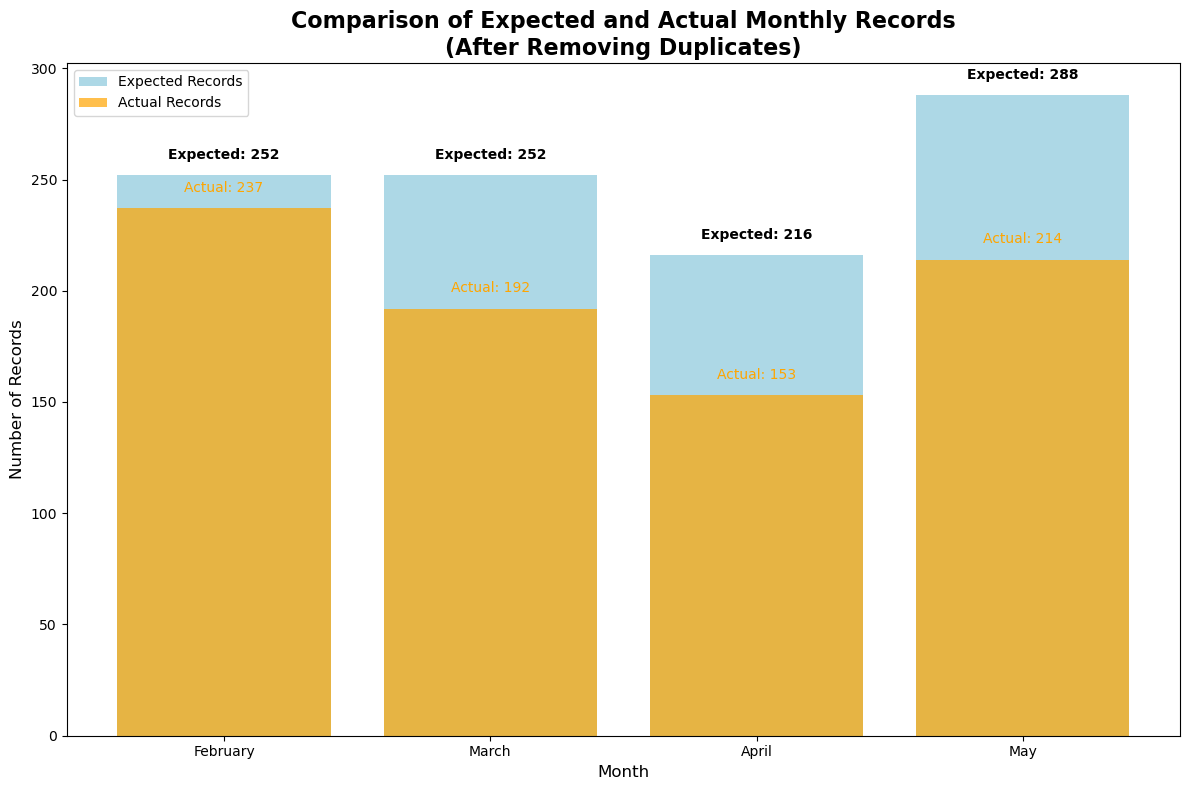

In [184]:
actual_records = deduplicated_df.groupby('month_name').size().reset_index(name='actual_records')
# Merge the actual and expected records
comparison_df3 = pd.merge(expected_records, actual_records, on='month_name', how='left')
comparison_df3['actual_records'] = comparison_df3['actual_records'].fillna(0)  # Fill NaNs with 0 if any month has no records
comparison_df3['difference'] = comparison_df3['actual_records'] - comparison_df3['expected_records']

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 8))
# Plot expected records
ax.bar(comparison_df3['month_name'], comparison_df3['expected_records'], label='Expected Records', color='lightblue')
# Plot actual records
ax.bar(comparison_df3['month_name'], comparison_df3['actual_records'], label='Actual Records', color='orange', alpha=0.7)

# Customize the chart
plt.title('Comparison of Expected and Actual Monthly Records\n(After Removing Duplicates)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.legend()

# Add text labels
for i, row in comparison_df3.iterrows():
    plt.text(i, row['expected_records'] + 6, f'Expected: {row["expected_records"]}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i, row['actual_records'] + 6, f'Actual: {row["actual_records"]}', ha='center', va='bottom', fontsize=10, color='orange')

# Show the plot
plt.tight_layout()
plt.show()

## Generating Trips Data

In [185]:
def create_trip_dataframe(gdf, route_col='route_id', time_col='time', geom_col='geometry_standard', stop_id_col='Stop_ID'):
    """
    Extends the GeoDataFrame with additional trip attributes.
    """
    # Sort the data by route and time to ensure correct sequence
    gdf_sorted = gdf.sort_values(by=[route_col, time_col])
    gdf_sorted['trip_id'] = gdf_sorted.groupby([route_col]).cumcount() + 1

    segments = []
    for _, group in gdf_sorted.groupby(route_col):
        last_row = None
        for idx, row in group.iterrows():
            if last_row is not None:
                # Create a LineString from the previous stop to the current stop
                line = LineString([last_row[geom_col], row[geom_col]])
                start_coords = (last_row[geom_col].y, last_row[geom_col].x)
                end_coords = (row[geom_col].y, row[geom_col].x)
                distance = geodesic(start_coords, end_coords).kilometers  # Calculate geographic distance
                duration = (row[time_col] - last_row[time_col]).total_seconds() / 60.0  # Duration in minutes

                segments.append({
                    'route_id': row[route_col],
                    'trip_id': last_row['trip_id'],
                    'start_time': last_row['time'],
                    'end_time': row['time'],
                    'start_hour': last_row['hour'],
                    'end_hour': row['hour'],
                    'start_stop': last_row['Stop_Name'],
                    'end_stop': row['Stop_Name'],
                    'start_stop_id': last_row[stop_id_col],
                    'end_stop_id': row[stop_id_col],
                    'start_lat': last_row[geom_col].y,
                    'start_lon': last_row[geom_col].x,
                    'end_lat': row[geom_col].y,
                    'end_lon': row[geom_col].x,
                    'duration': duration,
                    'distance': distance,
                    'segment': line
                })
            last_row = row

    # Convert the list of segments into a GeoDataFrame
    trips_gdf = gpd.GeoDataFrame(segments, geometry='segment')

    return trips_gdf

all_trips = create_trip_dataframe(deduplicated_df)

In [186]:
all_trips

,route_id,trip_id,start_time,end_time,start_hour,end_hour,start_stop,end_stop,start_stop_id,end_stop_id,start_lat,start_lon,end_lat,end_lon,duration,distance,segment
0,10,1,2024-02-01 06:54:08,2024-02-01 07:00:07,6,7,SPBU Tlogomas,SD Dinoyo 2,BT01,BT02,-7.93324,112.60354,-7.94329,112.61047,5.983333,1.348795,"LINESTRING (112.60354 -7.93324, 112.61047 -7.9..."
1,10,2,2024-02-01 07:00:07,2024-02-01 07:09:44,7,7,SD Dinoyo 2,SMA 9,BT02,BT03,-7.94329,112.61047,-7.94979,112.61559,9.616667,0.914033,"LINESTRING (112.61047 -7.94329, 112.61559 -7.9..."
2,10,3,2024-02-01 07:09:44,2024-02-01 07:11:05,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,1.350000,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
3,10,4,2024-02-01 07:11:05,2024-02-01 07:15:01,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,112.61047,-7.95658,112.61276,3.933333,1.491343,"LINESTRING (112.61047 -7.94329, 112.61276 -7.9..."
4,10,5,2024-02-01 07:15:01,2024-02-01 07:21:56,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,112.61276,-7.96334,112.62548,6.916667,1.589263,"LINESTRING (112.61276 -7.95658, 112.62548 -7.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,11,196,2024-05-27 16:26:11,2024-05-27 16:49:08,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,22.950000,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"
790,11,197,2024-05-27 16:49:08,2024-05-27 16:53:48,16,16,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,4.666667,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
791,11,198,2024-05-27 16:53:48,2024-05-28 16:11:09,16,16,SD Dinoyo 2,SMA Dempo,BT02,BT06,-7.94329,112.61047,-7.97250,112.62180,1397.350000,3.463606,"LINESTRING (112.61047 -7.94329, 112.6218 -7.9725)"
792,11,199,2024-05-28 16:11:09,2024-05-28 16:49:47,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,38.633333,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"


In [187]:
all_trips = create_trip_dataframe(standardized_filtered_deduped_df)
all_trips

,route_id,trip_id,start_time,end_time,start_hour,end_hour,start_stop,end_stop,start_stop_id,end_stop_id,start_lat,start_lon,end_lat,end_lon,duration,distance,segment
0,10,1,2024-02-01 06:54:08,2024-02-01 07:00:07,6,7,SPBU Tlogomas,SD Dinoyo 2,BT01,BT02,-7.93324,112.60354,-7.94329,112.61047,5.983333,1.348795,"LINESTRING (112.60354 -7.93324, 112.61047 -7.9..."
1,10,2,2024-02-01 07:00:07,2024-02-01 07:09:44,7,7,SD Dinoyo 2,SMA 9,BT02,BT03,-7.94329,112.61047,-7.94979,112.61559,9.616667,0.914033,"LINESTRING (112.61047 -7.94329, 112.61559 -7.9..."
2,10,3,2024-02-01 07:09:44,2024-02-01 07:11:05,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,1.350000,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
3,10,4,2024-02-01 07:11:05,2024-02-01 07:15:01,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,112.61047,-7.95658,112.61276,3.933333,1.491343,"LINESTRING (112.61047 -7.94329, 112.61276 -7.9..."
4,10,5,2024-02-01 07:15:01,2024-02-01 07:21:56,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,112.61276,-7.96334,112.62548,6.916667,1.589263,"LINESTRING (112.61276 -7.95658, 112.62548 -7.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,11,195,2024-05-27 16:26:11,2024-05-27 16:49:08,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,22.950000,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"
789,11,196,2024-05-27 16:49:08,2024-05-27 16:53:48,16,16,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,4.666667,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
790,11,197,2024-05-27 16:53:48,2024-05-28 16:11:09,16,16,SD Dinoyo 2,SMA Dempo,BT02,BT06,-7.94329,112.61047,-7.97250,112.62180,1397.350000,3.463606,"LINESTRING (112.61047 -7.94329, 112.6218 -7.9725)"
791,11,198,2024-05-28 16:11:09,2024-05-28 16:49:47,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,38.633333,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"


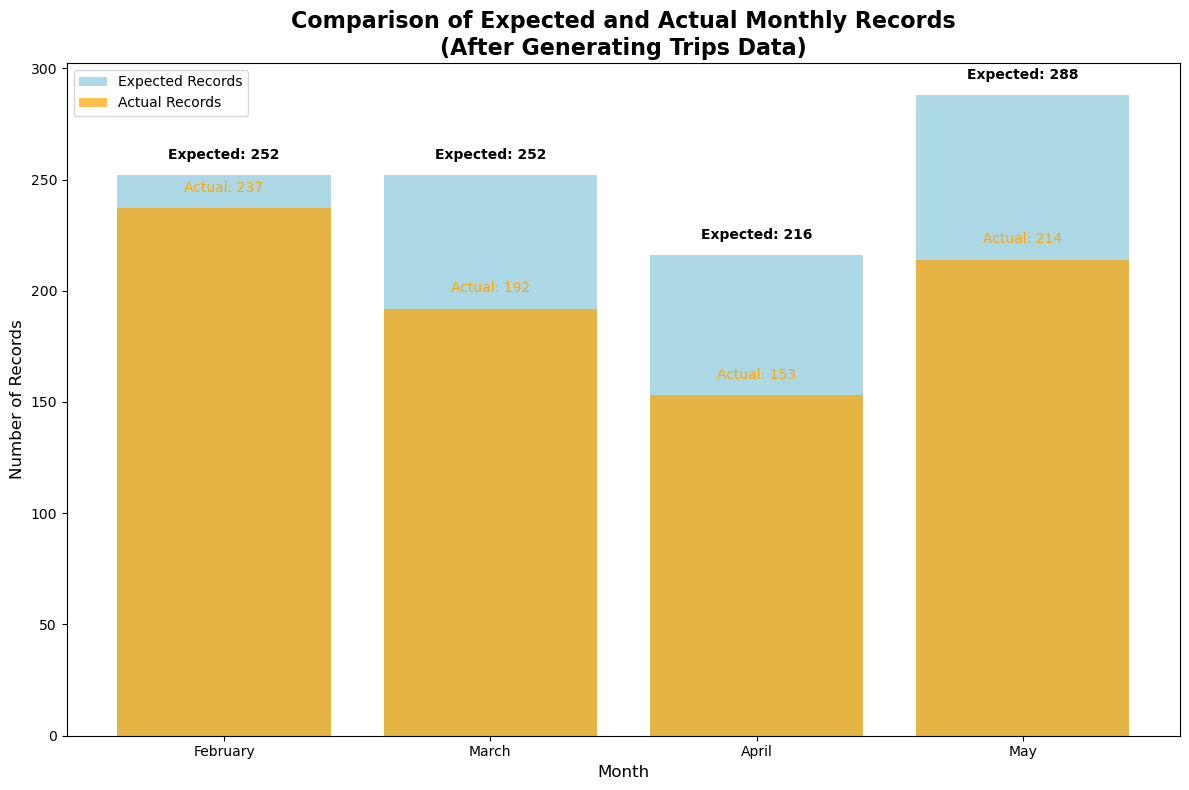

In [188]:
temp_df = all_trips.copy(deep=True)
temp_df['month_name'] = temp_df['start_time'].dt.strftime('%B')
actual_records4 = temp_df.groupby('month_name').size().reset_index(name='actual_records')
# Merge the actual and expected records
comparison_df4 = pd.merge(expected_records, actual_records, on='month_name', how='left')
comparison_df4['actual_records'] = comparison_df4['actual_records'].fillna(0)  # Fill NaNs with 0 if any month has no records
comparison_df4['difference'] = comparison_df4['actual_records'] - comparison_df4['expected_records']

# Plot the comparison
fig, ax = plt.subplots(figsize=(12, 8))
# Plot expected records
ax.bar(comparison_df4['month_name'], comparison_df4['expected_records'], label='Expected Records', color='lightblue')
# Plot actual records
ax.bar(comparison_df4['month_name'], comparison_df4['actual_records'], label='Actual Records', color='orange', alpha=0.7)

# Customize the chart
plt.title('Comparison of Expected and Actual Monthly Records\n(After Generating Trips Data)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.legend()

# Add text labels
for i, row in comparison_df4.iterrows():
    plt.text(i, row['expected_records'] + 6, f'Expected: {row["expected_records"]}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.text(i, row['actual_records'] + 6, f'Actual: {row["actual_records"]}', ha='center', va='bottom', fontsize=10, color='orange')

# Show the plot
plt.tight_layout()
plt.show()

In [175]:
print('Total Records:', len(all_trips))

Total Records: 793


## Removing Long Duration Trips

In [189]:
def remove_long_duration_trips(gdf, max_duration=30, duration_col='duration'):
    """
    Removes trips with durations exceeding a specified maximum from a GeoDataFrame.

    Parameters:
    gdf : GeoDataFrame
        The GeoDataFrame that includes a duration column representing trip durations.
    max_duration : int
        The maximum duration threshold in minutes beyond which records are removed.
    duration_col : str
        The name of the column in gdf that contains the duration data.

    Returns:
    GeoDataFrame
        A GeoDataFrame after removing trips with excessive duration.
    """
    # Filter out trips with duration greater than the specified maximum
    filtered_gdf = gdf[gdf[duration_col] <= max_duration]
    return filtered_gdf

# Applying the function to your monthly data
all_trips_filtered = remove_long_duration_trips(all_trips)


# Optionally, print the size of the original and filtered datasets to see how many entries were removed
print(f"Original: {len(all_trips)}, Filtered: {len(all_trips_filtered)}")

Original: 793, Filtered: 659


In [190]:
all_trips_filtered[(all_trips_filtered['duration'] > 0.0)]

,route_id,trip_id,start_time,end_time,start_hour,end_hour,start_stop,end_stop,start_stop_id,end_stop_id,start_lat,start_lon,end_lat,end_lon,duration,distance,segment
0,10,1,2024-02-01 06:54:08,2024-02-01 07:00:07,6,7,SPBU Tlogomas,SD Dinoyo 2,BT01,BT02,-7.93324,112.60354,-7.94329,112.61047,5.983333,1.348795,"LINESTRING (112.60354 -7.93324, 112.61047 -7.9..."
1,10,2,2024-02-01 07:00:07,2024-02-01 07:09:44,7,7,SD Dinoyo 2,SMA 9,BT02,BT03,-7.94329,112.61047,-7.94979,112.61559,9.616667,0.914033,"LINESTRING (112.61047 -7.94329, 112.61559 -7.9..."
2,10,3,2024-02-01 07:09:44,2024-02-01 07:11:05,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,1.350000,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
3,10,4,2024-02-01 07:11:05,2024-02-01 07:15:01,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,112.61047,-7.95658,112.61276,3.933333,1.491343,"LINESTRING (112.61047 -7.94329, 112.61276 -7.9..."
4,10,5,2024-02-01 07:15:01,2024-02-01 07:21:56,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,112.61276,-7.96334,112.62548,6.916667,1.589263,"LINESTRING (112.61276 -7.95658, 112.62548 -7.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,11,192,2024-05-22 16:32:45,2024-05-22 16:49:59,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,17.233333,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"
786,11,193,2024-05-22 16:49:59,2024-05-22 16:57:12,16,16,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,7.216667,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
788,11,195,2024-05-27 16:26:11,2024-05-27 16:49:08,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,22.950000,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"
789,11,196,2024-05-27 16:49:08,2024-05-27 16:53:48,16,16,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,4.666667,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."


# Exp

In [192]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from geopy.distance import geodesic
from datetime import timedelta

def create_trip_dataframe(gdf, route_col='route_id', time_col='time', geom_col='geometry_standard', stop_id_col='Stop_ID', max_gap=timedelta(minutes=30), min_stops=3):
    """
    Creates a GeoDataFrame of bus trips with refined trip identification.
    """
    gdf_sorted = gdf.sort_values(by=[route_col, time_col])
    
    segments = []
    current_trip = []
    last_row = None
    trip_id = 1

    for _, row in gdf_sorted.iterrows():
        if last_row is not None:
            time_gap = row[time_col] - last_row[time_col]
            
            if time_gap > max_gap or row[route_col] != last_row[route_col]:
                if len(current_trip) >= min_stops - 1:
                    segments.extend(current_trip)
                    trip_id += 1
                current_trip = []
            
            line = LineString([last_row[geom_col], row[geom_col]])
            start_coords = (last_row[geom_col].y, last_row[geom_col].x)
            end_coords = (row[geom_col].y, row[geom_col].x)
            distance = geodesic(start_coords, end_coords).kilometers
            duration = time_gap.total_seconds() / 60.0  # Duration in minutes

            segment = {
                'route_id': row[route_col],
                'trip_id': trip_id,
                'start_time': last_row[time_col],
                'end_time': row[time_col],
                'start_hour': last_row['hour'],
                'end_hour': row['hour'],
                'start_stop': last_row['Stop_Name'],
                'end_stop': row['Stop_Name'],
                'start_stop_id': last_row[stop_id_col],
                'end_stop_id': row[stop_id_col],
                'start_lat': last_row[geom_col].y,
                'start_lon': last_row[geom_col].x,
                'end_lat': row[geom_col].y,
                'end_lon': row[geom_col].x,
                'duration': duration,
                'distance': distance,
                'segment': line
            }
            current_trip.append(segment)
        
        last_row = row

    # Add the last trip if it meets the minimum stops criterion
    if len(current_trip) >= min_stops - 1:
        segments.extend(current_trip)

    # Convert the list of segments into a GeoDataFrame
    trips_gdf = gpd.GeoDataFrame(segments, geometry='segment')

    return trips_gdf

# Use the function
all_trips = create_trip_dataframe(deduplicated_df)

print(f"Total number of trip segments: {len(all_trips)}")
print(f"Number of unique trips: {all_trips['trip_id'].nunique()}")

print("\nTrip statistics:")
trip_stats = all_trips.groupby('trip_id').agg({
    'route_id': 'first',
    'start_time': 'min',
    'end_time': 'max',
    'duration': 'sum',
    'distance': 'sum',
    'start_stop': 'first',
    'end_stop': 'last'
}).reset_index()

trip_stats['total_duration'] = (trip_stats['end_time'] - trip_stats['start_time']).dt.total_seconds() / 60
trip_stats['stops'] = all_trips.groupby('trip_id')['start_stop'].nunique()

print(trip_stats.describe())

print("\nDistribution of stops per trip:")
print(trip_stats['stops'].value_counts().sort_index())

# Save the trip summary to a CSV file
trip_stats.to_csv('bus_trips_summary_refined.csv', index=False)
print("\nRefined trip summary saved to 'bus_trips_summary_refined.csv'")

Total number of trip segments: 783
Number of unique trips: 123

Trip statistics:
          trip_id    route_id                     start_time  \
count  123.000000  123.000000                            123   
mean    62.000000   10.439024  2024-03-29 03:12:46.024390144   
min      1.000000   10.000000            2024-02-01 06:54:08   
25%     31.500000   10.000000     2024-02-26 12:29:45.500000   
50%     62.000000   10.000000            2024-03-22 07:46:55   
75%     92.500000   11.000000            2024-05-02 00:17:00   
max    123.000000   11.000000            2024-05-30 07:28:56   
std     35.651087    0.498298                            NaN   

                            end_time       duration    distance  \
count                            123     123.000000  123.000000   
mean   2024-03-30 22:21:07.056910592    1187.563686   10.369768   
min              2024-02-01 07:29:43 -172245.066667    0.914033   
25%       2024-02-27 12:24:42.500000    1436.441667    6.980915   
50%    

Total number of trip segments: 794

Trip segment statistics:
           duration    distance
count    794.000000  794.000000
mean     429.943535    1.650086
std     1569.912913    1.431992
min        0.766667    0.000000
25%        2.862500    0.914033
50%        5.883333    1.348795
75%       12.662500    1.589263
max    25963.533333    5.846895

Segments per route:
route_id
10    594
11    200
Name: count, dtype: int64

Most common trip segments (top 10):
start_stop     end_stop     
SMA 9          SD Dinoyo 2      105
               SMA 9             84
SD Dinoyo 2    SMA 8             65
               SMA 9             63
SPBU Tlogomas  SD Dinoyo 2       60
SMA 8          MAN 2             54
SMA Dempo      SMP 4             50
MAN 2          SMA Dempo         48
SMP 4          SPBU Tlogomas     45
SMA Dempo      SMA 9             44
dtype: int64

Average duration between stops (minutes):
start_stop     end_stop     
SMA Dempo      SMA 8            9331.975000
SMP 4          SMA 8

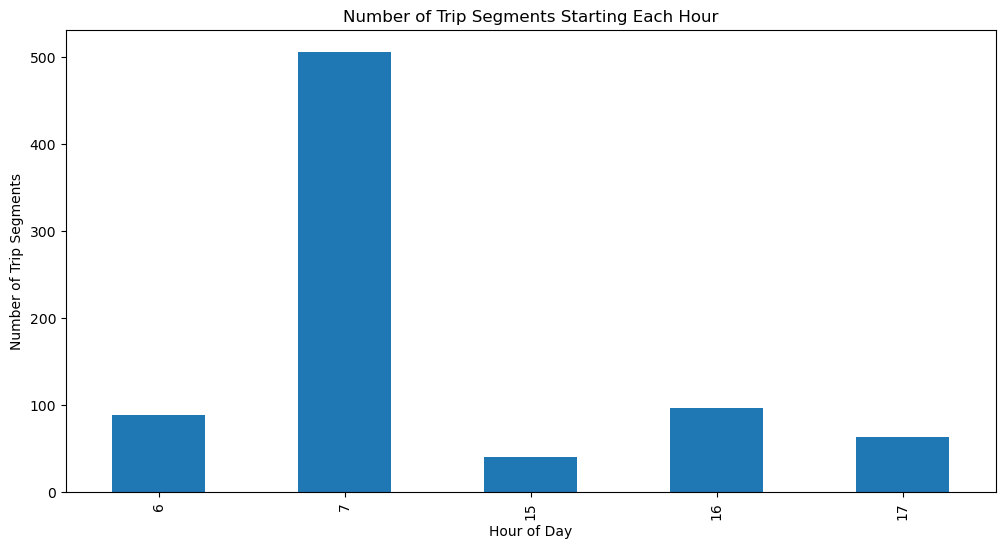

In [194]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from geopy.distance import geodesic

def create_trip_segments(gdf, route_col='route_id', time_col='time', geom_col='geometry_standard', stop_id_col='Stop_ID'):
    """
    Creates a GeoDataFrame of bus trip segments.
    """
    gdf_sorted = gdf.sort_values(by=[route_col, time_col])
    gdf_sorted['trip_id'] = gdf_sorted.groupby(route_col).cumcount() + 1

    segments = []
    for _, group in gdf_sorted.groupby(route_col):
        for (idx1, row1), (idx2, row2) in zip(group.iterrows(), group.iloc[1:].iterrows()):
            line = LineString([row1[geom_col], row2[geom_col]])
            start_coords = (row1[geom_col].y, row1[geom_col].x)
            end_coords = (row2[geom_col].y, row2[geom_col].x)
            distance = geodesic(start_coords, end_coords).kilometers
            duration = (row2[time_col] - row1[time_col]).total_seconds() / 60.0  # Duration in minutes

            segments.append({
                'route_id': row1[route_col],
                'trip_id': row1['trip_id'],
                'start_time': row1[time_col],
                'end_time': row2[time_col],
                'start_hour': row1['hour'],
                'end_hour': row2['hour'],
                'start_stop': row1['Stop_Name'],
                'end_stop': row2['Stop_Name'],
                'start_stop_id': row1[stop_id_col],
                'end_stop_id': row2[stop_id_col],
                'start_lat': row1[geom_col].y,
                'start_lon': row1[geom_col].x,
                'end_lat': row2[geom_col].y,
                'end_lon': row2[geom_col].x,
                'duration': duration,
                'distance': distance,
                'segment': line
            })

    return gpd.GeoDataFrame(segments, geometry='segment')

# Use the function
trip_segments = create_trip_segments(deduplicated_df)

print(f"Total number of trip segments: {len(trip_segments)}")

print("\nTrip segment statistics:")
print(trip_segments[['duration', 'distance']].describe())

print("\nSegments per route:")
print(trip_segments['route_id'].value_counts())

print("\nMost common trip segments (top 10):")
print(trip_segments.groupby(['start_stop', 'end_stop']).size().sort_values(ascending=False).head(10))

print("\nAverage duration between stops (minutes):")
print(trip_segments.groupby(['start_stop', 'end_stop'])['duration'].mean().sort_values(ascending=False).head(10))

print("\nTime of day analysis:")
trip_segments['start_hour'] = trip_segments['start_time'].dt.hour
hourly_trips = trip_segments['start_hour'].value_counts().sort_index()
print(hourly_trips)

# Visualization of hourly trips 
try:
    plt.figure(figsize=(12, 6))
    hourly_trips.plot(kind='bar')
    plt.title('Number of Trip Segments Starting Each Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trip Segments')
    plt.savefig('hourly_trip_segments.png')
    print("\nHourly trip segments chart saved as 'hourly_trip_segments.png'")
except ImportError:
    print("\nMatplotlib not available for visualization. Skipping chart creation.")

# Save the trip segments summary to a CSV file
trip_segments.drop(columns=['segment']).to_csv('bus_trip_segments_summary.csv', index=False)
print("\nTrip segments summary saved to 'bus_trip_segments_summary.csv'")

In [195]:
trip_segments

,route_id,trip_id,start_time,end_time,start_hour,end_hour,start_stop,end_stop,start_stop_id,end_stop_id,start_lat,start_lon,end_lat,end_lon,duration,distance,segment
0,10,1,2024-02-01 06:54:08,2024-02-01 07:00:07,6,7,SPBU Tlogomas,SD Dinoyo 2,BT01,BT02,-7.93324,112.60354,-7.94329,112.61047,5.983333,1.348795,"LINESTRING (112.60354 -7.93324, 112.61047 -7.9..."
1,10,2,2024-02-01 07:00:07,2024-02-01 07:09:44,7,7,SD Dinoyo 2,SMA 9,BT02,BT03,-7.94329,112.61047,-7.94979,112.61559,9.616667,0.914033,"LINESTRING (112.61047 -7.94329, 112.61559 -7.9..."
2,10,3,2024-02-01 07:09:44,2024-02-01 07:11:05,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,1.350000,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
3,10,4,2024-02-01 07:11:05,2024-02-01 07:15:01,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,112.61047,-7.95658,112.61276,3.933333,1.491343,"LINESTRING (112.61047 -7.94329, 112.61276 -7.9..."
4,10,5,2024-02-01 07:15:01,2024-02-01 07:21:56,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,112.61276,-7.96334,112.62548,6.916667,1.589263,"LINESTRING (112.61276 -7.95658, 112.62548 -7.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,11,196,2024-05-27 16:26:11,2024-05-27 16:49:08,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,22.950000,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"
790,11,197,2024-05-27 16:49:08,2024-05-27 16:53:48,16,16,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,4.666667,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
791,11,198,2024-05-27 16:53:48,2024-05-28 16:11:09,16,16,SD Dinoyo 2,SMA Dempo,BT02,BT06,-7.94329,112.61047,-7.97250,112.62180,1397.350000,3.463606,"LINESTRING (112.61047 -7.94329, 112.6218 -7.9725)"
792,11,199,2024-05-28 16:11:09,2024-05-28 16:49:47,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,38.633333,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"


In [196]:
trip_segments_filtered = trip_segments[trip_segments['start_stop_id']!=trip_segments['end_stop_id']]

In [197]:
trip_segments_filtered

,route_id,trip_id,start_time,end_time,start_hour,end_hour,start_stop,end_stop,start_stop_id,end_stop_id,start_lat,start_lon,end_lat,end_lon,duration,distance,segment
0,10,1,2024-02-01 06:54:08,2024-02-01 07:00:07,6,7,SPBU Tlogomas,SD Dinoyo 2,BT01,BT02,-7.93324,112.60354,-7.94329,112.61047,5.983333,1.348795,"LINESTRING (112.60354 -7.93324, 112.61047 -7.9..."
1,10,2,2024-02-01 07:00:07,2024-02-01 07:09:44,7,7,SD Dinoyo 2,SMA 9,BT02,BT03,-7.94329,112.61047,-7.94979,112.61559,9.616667,0.914033,"LINESTRING (112.61047 -7.94329, 112.61559 -7.9..."
2,10,3,2024-02-01 07:09:44,2024-02-01 07:11:05,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,1.350000,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
3,10,4,2024-02-01 07:11:05,2024-02-01 07:15:01,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,112.61047,-7.95658,112.61276,3.933333,1.491343,"LINESTRING (112.61047 -7.94329, 112.61276 -7.9..."
4,10,5,2024-02-01 07:15:01,2024-02-01 07:21:56,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,112.61276,-7.96334,112.62548,6.916667,1.589263,"LINESTRING (112.61276 -7.95658, 112.62548 -7.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,11,196,2024-05-27 16:26:11,2024-05-27 16:49:08,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,22.950000,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"
790,11,197,2024-05-27 16:49:08,2024-05-27 16:53:48,16,16,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,112.61559,-7.94329,112.61047,4.666667,0.914033,"LINESTRING (112.61559 -7.94979, 112.61047 -7.9..."
791,11,198,2024-05-27 16:53:48,2024-05-28 16:11:09,16,16,SD Dinoyo 2,SMA Dempo,BT02,BT06,-7.94329,112.61047,-7.97250,112.62180,1397.350000,3.463606,"LINESTRING (112.61047 -7.94329, 112.6218 -7.9725)"
792,11,199,2024-05-28 16:11:09,2024-05-28 16:49:47,16,16,SMA Dempo,SMA 9,BT06,BT03,-7.97250,112.62180,-7.94979,112.61559,38.633333,2.603276,"LINESTRING (112.6218 -7.9725, 112.61559 -7.94979)"


In [207]:
trip_segments_filtered = remove_long_duration_trips(trip_segments_filtered)
trip_segments_filtered.drop(columns=['segment', 'trip_id'],inplace=True)

In [208]:
trip_segments_filtered.to_csv('D:\\CDS590\\data\\processed\\trip_segments_feb_march_april_may.csv', index=False)